# nuScenes Tutorial

In [1]:
import numpy as np
import random
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper

nusc_root = "/scratch/e0196773/data/nuScenes_trainval_meta_v1.0"
nusc = NuScenes("v1.0-trainval", dataroot=str(nusc_root))
helper = PredictHelper(nusc)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 26.921 seconds.
Reverse indexing ...
Done reverse indexing in 5.9 seconds.


map_name: boston-seaport
ego_info: {'token': '6533f29bd79c46e3991cb0de9d74a5b2', 'sample_token': 'a3cbed1b71c54b1cb067b434284cf955', 'instance_token': '34733eed540a497194c75fa33351bad9', 'visibility_token': '4', 'attribute_tokens': ['cb5118da1ab342aa947717dc53544259'], 'translation': [1775.971, 1214.316, 1.488], 'size': [2.719, 7.409, 3.431], 'rotation': [-0.18395135063393106, 0.0, 0.0, 0.9829353491455848], 'prev': '8cdb40fdd6374f64840f8e58ef47c6ca', 'next': 'ef1e340623364dae89477e069f6a21a3', 'num_lidar_pts': 90, 'num_radar_pts': 8, 'category_name': 'vehicle.bus.bendy'}
VehiclePose(x=1775.971, y=1214.316, psi=0.37000980146595613, bbox=array([[1772.02557788, 1214.24385599],
       [1773.00883508, 1211.70886757],
       [1779.91642212, 1214.38814401],
       [1778.93316492, 1216.92313243]]), length=7.409, width=2.719)


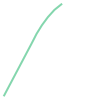

In [12]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point
from nuscenes.eval.prediction.splits import get_prediction_challenge_split
from lanelet2anchors import AnchorGenerator
from lanelet2anchors.anchor_tools.nusc import load_agent_from_sample, NUSC_ORIGIN_MAP
from lanelet2anchors.anchor_tools.visualize import plot_trajectory_and_anchors
from lanelet2anchors.anchor_tools.lanelet_matching import VehiclePose

get_map_name = lambda scene_token: nusc.get(
    "log", nusc.get("scene", scene_token)["log_token"]
)["location"]

# Load example instance
# Requires download of data/nuscenes_mini/maps/prediction/prediction_scenes.json
# mini_train = get_prediction_challenge_split("mini_train", dataroot=nusc_root)
# instance_token, sample_token = random.choice(mini_train).split("_")

instance_token, sample_token = (
    "34733eed540a497194c75fa33351bad9",
    "a3cbed1b71c54b1cb067b434284cf955",
)
annotation = helper.get_sample_annotation(instance_token, sample_token)

# Get scene and map info
scene_token = nusc.get("sample", annotation["sample_token"])["scene_token"]
map_name = get_map_name(scene_token)
print(f'map_name: {map_name}')
ll_map = AnchorGenerator(f"/home/svu/e0196773/lanelet2anchors/osm_files/{map_name}.osm", *NUSC_ORIGIN_MAP[map_name])
try:
    # Requires download of data/nuscenes_mini/maps/expansion/*
    nusc_map = NuScenesMap(dataroot=nusc_root, map_name=map_name)
except Exception as e:
    print(f"Couldn't load nuScenes map: {repr(e)}")
    nusc_map = None

# Save ego poses
width, length, height = annotation["size"]
ego_info = helper.get_sample_annotation(sample_token=sample_token, instance_token=instance_token)
print(f'ego_info: {ego_info}')
vehicle_pose = VehiclePose.from_nusc(
    ego_info['translation'][0], ego_info['translation'][1], ego_info['rotation'], width, length
)

print(vehicle_pose)
# Save GT trajectory
ego_future_traj = helper.get_future_for_agent(instance_token, sample_token,
                                                       seconds=6, in_agent_frame=False, just_xy=False)
ego_future_pose = np.array([r['translation'][:3] for r in ego_future_traj])
gt_trajectory = LineString(
    [Point(pose) for pose in ego_future_pose]
)
gt_trajectory


## Visualization of Lanelet Matching and Anchor Generation

Note that lanelet matching probabilities do not always sum up to 100% since no anchors might have been sampled for certain matched lanelets.

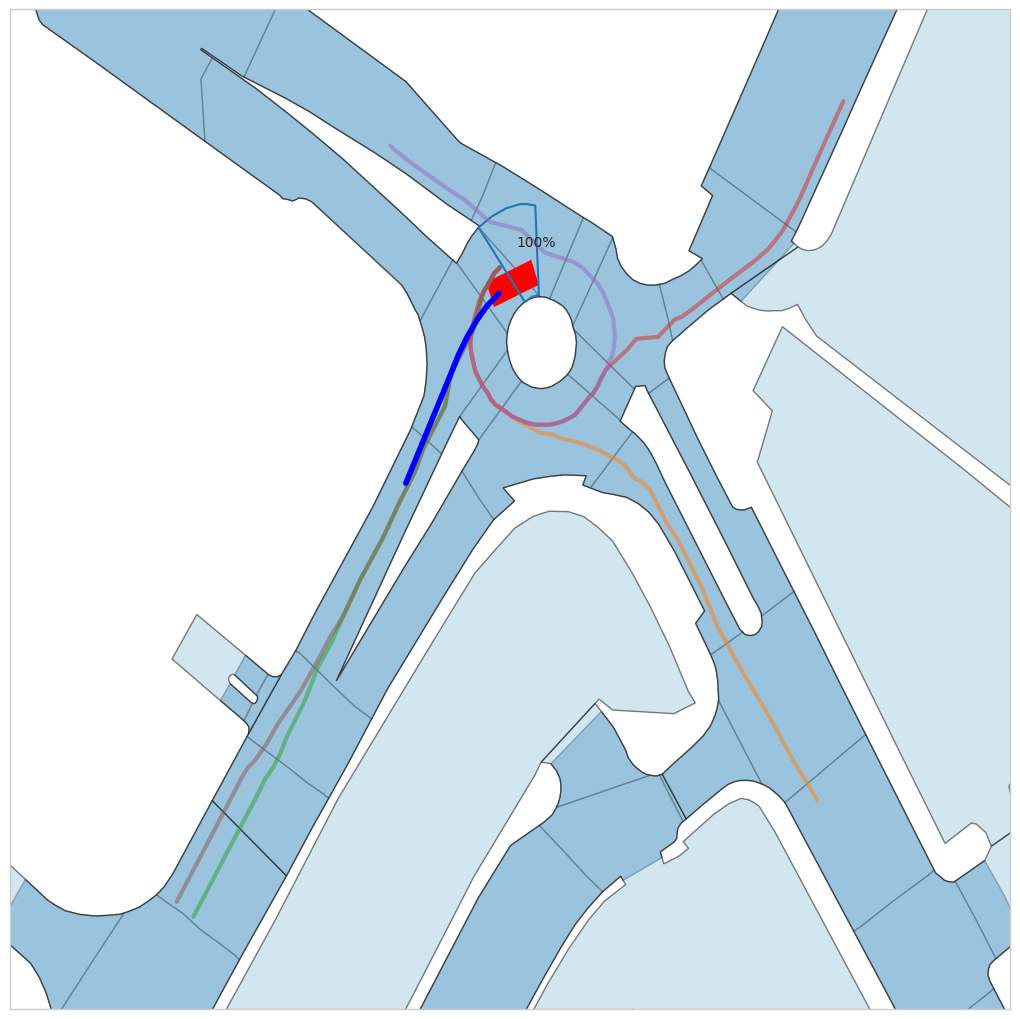

In [16]:
anchor_length = 100
# Compute anchors with DMAP
anchor_paths = ll_map.create_anchors_for_vehicle(
    vehicle_pose, anchor_length, num_anchors=5,
    probabilitisc_matching=True
)

# Visualize result
if len(anchor_paths) > 0 and nusc_map is not None:
    fig, ax = plot_trajectory_and_anchors(
        gt_trajectory,
        anchor_paths,
        vehicle_pose,
        nusc_map,
        vis_type="all_dmap",
    )
    plt.show()

### Reachable lanelets

In [17]:
reachable_lanelets = ll_map.get_reachable_lanelets_for_vehicle(
    vehicle_pose, anchor_length,
    probabilitisc_matching=False
)
reachable_lanelets[0]

AttributeError: 'AnchorGenerator' object has no attribute 'get_reachable_lanelets_for_vehicle'